## Project Overview & Class Distribution

This project aims to classify dental images into 7 distinct categories. Understanding the dataset balance is crucial for model training.

**Classes:**
- The dataset contains 7 classes (folders): CaS, CoS, Gum, MC, OC, OLP, OT.

In [116]:
import os
import time
import copy
import random
from torchvision import datasets
from typing import Optional, Callable, List, Dict, Any, Tuple
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

## Configuration

In [117]:
# Config
DATA_DIR = "/kaggle/input/teeth-classification-dataset/Teeth_Dataset"
TRAIN_DIR = os.path.join(DATA_DIR, 'Training')
VAL_DIR = os.path.join(DATA_DIR, 'Validation')
TEST_DIR = os.path.join(DATA_DIR, 'Testing')

BATCH_SIZE = 64
LEARNING_RATE = 1e-3
EPOCHS = 100
IMG_SIZE = 224
NUM_CLASSES = 7

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Class Distribution
**Class weights** will be used to handle the imbalance.

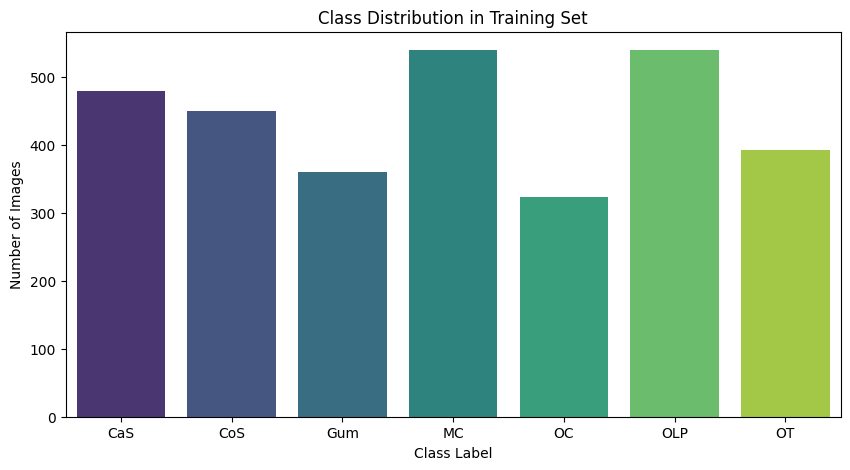

In [118]:
classes = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
train_counts = [len(os.listdir(os.path.join(TRAIN_DIR, cls))) for cls in classes]

df_dist = pd.DataFrame({'Class': classes, 'Count': train_counts})

plt.figure(figsize=(10, 5))
sns.barplot(x='Class', y='Count', data=df_dist, hue='Class', palette='viridis', legend=False)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.show()

## Visualizing the dataset

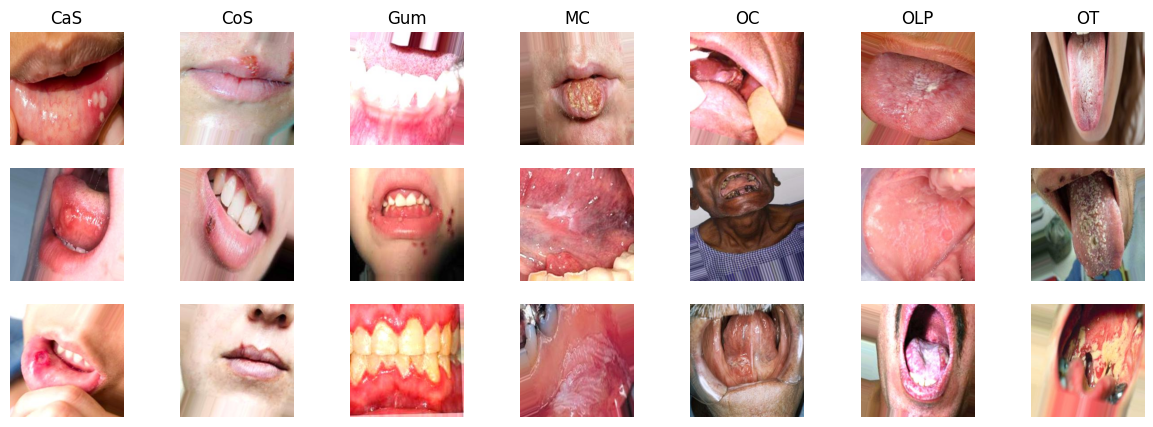

In [119]:
# Visualize different classes
rows = 3
plt.figure(figsize=(15, 5))
for i, cls in enumerate(classes):
    if os.path.isdir(os.path.join(TRAIN_DIR, cls)):
        for row in range(rows):
            img_name = random.choice(os.listdir(os.path.join(TRAIN_DIR, cls)))
            img_path = os.path.join(TRAIN_DIR, cls, img_name)
            img = Image.open(img_path)
            
            plt.subplot(rows, len(classes), row * len(classes) + i + 1)
            plt.imshow(img.resize((IMG_SIZE, IMG_SIZE)))
            if row == 0:
                plt.title(cls)
            plt.axis('off')
plt.show()

## Data Augmentation Visualization

Data Augmentation is applied to the training set to improve generalization. Additionally, a raw image is compared with its augmented version to verify the transformations.

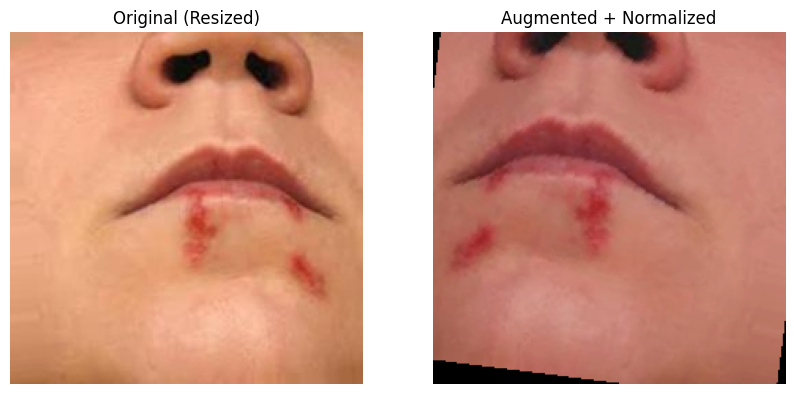

In [120]:
# Define Transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Visualization Helper
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)

# Pick random image to visualize
demo_class = random.choice(classes)
demo_img_name = random.choice(os.listdir(os.path.join(TRAIN_DIR, demo_class)))
demo_img_path = os.path.join(TRAIN_DIR, demo_class, demo_img_name)
original_img = Image.open(demo_img_path)

# Apply Transform
augmented_img = data_transforms['train'](original_img)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_img.resize((IMG_SIZE, IMG_SIZE)))
plt.title("Original (Resized)")
plt.axis('off')

plt.subplot(1, 2, 2)
imshow(augmented_img, title="Augmented + Normalized")
plt.axis('off')

plt.show()

## Data Loaders

In [121]:
class FilteredImageFolder(datasets.ImageFolder):
    def __init__(
        self,
        root: str,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        loader: Callable[[str], Any] = datasets.folder.default_loader,
        is_valid_file: Optional[Callable[[str], bool]] = None,
        classes: Optional[List[str]] = None,
    ):
        self.filter_classes = classes
        super().__init__(root, transform, target_transform, loader, is_valid_file)

    def find_classes(self, directory: str) -> Tuple[List[str], Dict[str, int]]:
        if self.filter_classes:
            classes = sorted(self.filter_classes)
            class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
            return classes, class_to_idx
        else:
            return super().find_classes(directory)

# 1. Load Train Dataset
train_dataset = datasets.ImageFolder(TRAIN_DIR, data_transforms['train'])
class_names = train_dataset.classes
print(f"Train Classes: {class_names}")

# 2. Load Val and Test Datasets using FilteredImageFolder with the training classes
image_datasets = {
    'train': train_dataset,
    'val': FilteredImageFolder(VAL_DIR, data_transforms['val'], classes=class_names),
    'test': FilteredImageFolder(TEST_DIR, data_transforms['test'], classes=class_names)
}

num_workers = os.cpu_count()
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=(x=='train'), num_workers=num_workers)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
print(f"Dataset Sizes: {dataset_sizes}")

Train Classes: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']
Dataset Sizes: {'train': 3087, 'val': 1028, 'test': 1028}


## Model Definition

In [122]:
class TeethClassifier(nn.Module):
    def __init__(self, num_classes=7):
        super(TeethClassifier, self).__init__()
        
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True), # inplace = true: save memory as The computer modifies the data directly in the original memory location.
            nn.MaxPool2d(2, 2),
            
            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Block 5
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Block 6
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(1024, 2048),
            nn.ReLU(inplace=True),
            # nn.Dropout(0.5),
            nn.Linear(2048, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = TeethClassifier(NUM_CLASSES).to(device)
print(model)

TeethClassifier(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0

## Training Setup
Using Class Weights, AdamW, Early Stopping, and Learning Rate Scheduler.

In [123]:
# Calculate Class Weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(image_datasets['train'].targets), y=image_datasets['train'].targets)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"Class Weights: {class_weights}")

# Optimizer, Loss, Scheduler
criterion = nn.NLLLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

Class Weights: tensor([0.9187, 0.9800, 1.2250, 0.8167, 1.3611, 0.8167, 1.1221],
       device='cuda:0')


## Training Loop

In [124]:
# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def train_model(model, criterion, optimizer, scheduler, num_epochs=25, patience=5):
    since = time.time()
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    torch.save(model.state_dict(), 'best_model.pth')
    best_acc = 0.0
    
    early_stopping = EarlyStopping(patience=patience)

    for epoch in range(1, num_epochs + 1):
        print(f'Epoch {epoch}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                
                # Step the scheduler
                scheduler.step(epoch_loss)

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), 'best_model.pth')

                # Check early stopping
                early_stopping(epoch_loss)
                if early_stopping.early_stop:
                    print("Early stopping")
                    model.load_state_dict(best_model_wts)
                    return model, history
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, history

model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=EPOCHS, patience=5)

Epoch 1/100
----------
train Loss: 1.9366 Acc: 0.2190
val Loss: 1.8185 Acc: 0.2831

Epoch 2/100
----------
train Loss: 1.7216 Acc: 0.2909
val Loss: 1.6897 Acc: 0.3288

Epoch 3/100
----------
train Loss: 1.6268 Acc: 0.3304
val Loss: 1.6386 Acc: 0.3161

Epoch 4/100
----------
train Loss: 1.5247 Acc: 0.3848
val Loss: 1.3722 Acc: 0.4348

Epoch 5/100
----------
train Loss: 1.3976 Acc: 0.4454
val Loss: 1.5780 Acc: 0.3959

Epoch 6/100
----------
train Loss: 1.2299 Acc: 0.5070
val Loss: 1.1855 Acc: 0.5593

Epoch 7/100
----------
train Loss: 1.1886 Acc: 0.5309
val Loss: 1.2004 Acc: 0.5292

Epoch 8/100
----------
train Loss: 1.0776 Acc: 0.5818
val Loss: 1.6187 Acc: 0.4543

Epoch 9/100
----------
train Loss: 0.9976 Acc: 0.6087
val Loss: 1.0073 Acc: 0.6148

Epoch 10/100
----------
train Loss: 0.9105 Acc: 0.6514
val Loss: 1.1094 Acc: 0.6265

Epoch 11/100
----------
train Loss: 0.8373 Acc: 0.6825
val Loss: 0.7562 Acc: 0.7198

Epoch 12/100
----------
train Loss: 0.7943 Acc: 0.6981
val Loss: 1.2964 Ac

## Visualization
Plotting Error vs Epochs and Accuracy.

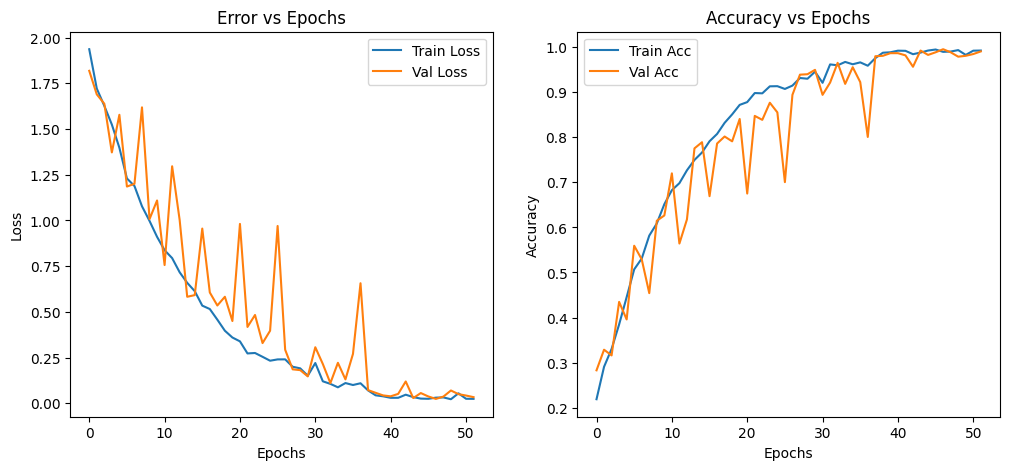

In [125]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Error vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Evaluation (Test Set)

In [126]:
def evaluate_model(model, loader, criterion=None, device=None):
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0.0
    num_samples = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            if criterion:
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                num_samples += inputs.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    avg_loss = running_loss / num_samples if criterion and num_samples > 0 else None
    return np.array(all_labels), np.array(all_preds), avg_loss

# Run evaluation with loss calculation
y_true, y_pred, test_loss = evaluate_model(model, dataloaders['test'], criterion, device)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {accuracy_score(y_true, y_pred):.4f}')

Test Loss: 0.0316
Test Accuracy: 0.9903


### Confusion Matrix

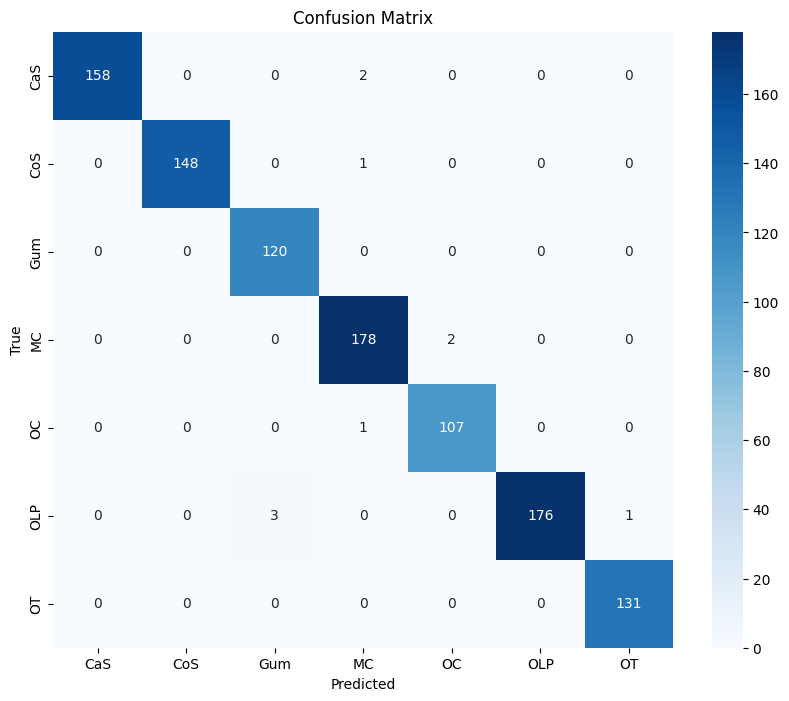

In [127]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Precision and Recall Table

In [128]:
report = classification_report(y_true, y_pred, labels=list(range(len(class_names))), target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print("Classification Report:")
display(df_report)

Classification Report:


,precision,recall,f1-score,support
CaS,1.000000,0.987500,0.993711,160.000000
CoS,1.000000,0.993289,0.996633,149.000000
Gum,0.975610,1.000000,0.987654,120.000000
MC,0.978022,0.988889,0.983425,180.000000
OC,0.981651,0.990741,0.986175,108.000000
OLP,1.000000,0.977778,0.988764,180.000000
OT,0.992424,1.000000,0.996198,131.000000
accuracy,0.990272,0.990272,0.990272,0.990272
macro avg,0.989672,0.991171,0.990366,1028.000000
weighted avg,0.990412,0.990272,0.990285,1028.000000
